In [1]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
from random import randint
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score, log_loss
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline

df = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')

In [2]:
#Разведочный анализ
print('Число строк и колонок в таблице: ', df.shape)
print('Типы данных в колонках:', '\n', df.dtypes)

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('Колонки с числовыми значениями:', '\n', numeric_cols)

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print('Колонки с объектными значениями:', '\n', non_numeric_cols)

print('Пропущенные значения в колонках:', '\n', df.isnull().sum())

Число строк и колонок в таблице:  (891, 12)
Типы данных в колонках: 
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Колонки с числовыми значениями: 
 ['PassengerId' 'Survived' 'Pclass' 'Age' 'SibSp' 'Parch' 'Fare']
Колонки с объектными значениями: 
 ['Name' 'Sex' 'Ticket' 'Cabin' 'Embarked']
Пропущенные значения в колонках: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [3]:
#Построение гистограмм для всех колонок 
def show_hist(df):
    for col in df.columns:
        df[col].iplot(kind='hist', title=col)
        
show_hist(df)

PassengerId - 0%
Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 20%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 77%
Embarked - 0%


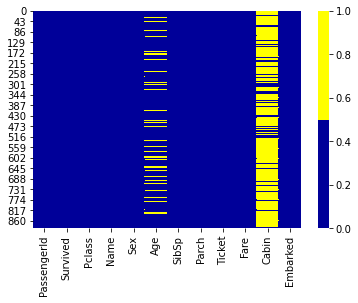

In [4]:
#Тепловая карта и статистика пропущенных значений
sns.heatmap(df[df.columns].isnull(), cmap=sns.color_palette(['#000099', '#ffff00'])) #желтый - пропущенные данные

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [5]:
#Проверка на корреляцию

In [6]:
#Отбор колонок для тренировки модели

In [7]:
#Чистка данных и их подгонка для обучения

In [8]:
#Проверка тестовой выборки, можно ли на ней строить предсказание

In [9]:
df = df.drop(['Name', 'Ticket', 'Cabin', ], axis=1) 

In [10]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

In [11]:
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [12]:
df['Age'] = df.Age.fillna(df.Age.mean())

In [13]:
df['Embarked'] = df.Embarked.fillna(0)

In [14]:
Q1 = df['Fare'].quantile(0.05)
Q3 = df['Fare'].quantile(0.90)
IQR = Q3 - Q1
df = df[(df['Fare'] > (Q1-1.5*IQR)) & (df['Fare'] < (Q3+1.5*IQR))]

In [15]:
#Создаем фрейм для предсказания
X_to_be_predicted = tsd.drop(['Name', 'Ticket', 'Cabin'], axis=1) 
X_to_be_predicted['Sex'] = LabelEncoder().fit_transform(X_to_be_predicted['Sex'])
X_to_be_predicted['Embarked'] = X_to_be_predicted['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
X_to_be_predicted['Age'] = X_to_be_predicted.Age.fillna(df.Age.mean())
X_to_be_predicted['Fare'] = X_to_be_predicted.Age.fillna(30)

In [16]:
#Подготовка обучающей и тестовых выборок
train_data = df #Выбираем фрейм
train_data = train_data.dropna() #В новом фрейме чистим от пустых строк
y = train_data['Survived'] #Зависимая переменная
X = train_data.drop(['Survived'], axis = 1) #Предикторы
train_data.shape 

(871, 9)

In [17]:
#Расщепление на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,                                                    
                                                    test_size=0.2 # доля объёма тестового множества
                                                   )

In [27]:
model = RandomForestClassifier(criterion='entropy', 
                               n_estimators=700,
                               min_samples_split=10,
                               min_samples_leaf=1,
                               max_depth=6, #Макс число слоев 
                               max_features='auto',
                               oob_score=True,
                               random_state=42,
                               n_jobs=-1,
                               warm_start=False, #использовать результаты предыдущего вызова и нарастить предыдущий лес
                               class_weight=None )

model.fit(X_train, y_train)
result = model.predict(X_to_be_predicted)

print("RF Accuracy: "+repr(round(model.score(X_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(model, X_train, y_train, cv=10)

#Важность вклада предикторов
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

RF Accuracy: 81.71%
The cross validated score for Random forest is: 82.45


,feature,importance
2,Sex,0.343713
6,Fare,0.172090
1,Pclass,0.135447
3,Age,0.120839
0,PassengerId,0.089798
4,SibSp,0.054417
7,Embarked,0.044572
5,Parch,0.039123


In [19]:
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_test_predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic_test_predictions.csv
